In [1]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score


In [23]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset path
dataset_dir = os.path.join("D:/DEVPOST/AI_MODEL (AI-IN -Action)", "brain_tumor_dataset")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])



In [24]:
# Load dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

# Split dataset into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [25]:
# CNN Model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (3 input channels for RGB)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = BrainTumorCNN(num_classes).to(device)

In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    best_acc = 0

    # Learning rate scheduler: halve LR every 10 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion)

        # Append to track progress
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.2f}%')

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_brain_tumor_model.pth')
            print(f'✅ Best model saved at epoch {epoch+1} with {val_acc:.2f}% validation accuracy.')

        # Step the scheduler
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies


In [31]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    return acc, avg_loss


In [33]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


Epoch [1/100], Train Loss: 0.4136, Train Acc: 82.67%, Val Loss: 0.5567, Val Acc: 72.55%
✅ Best model saved at epoch 1 with 72.55% validation accuracy.
Epoch [2/100], Train Loss: 0.3966, Train Acc: 80.20%, Val Loss: 0.5406, Val Acc: 80.39%
✅ Best model saved at epoch 2 with 80.39% validation accuracy.
Epoch [3/100], Train Loss: 0.3964, Train Acc: 83.66%, Val Loss: 0.5000, Val Acc: 80.39%
Epoch [4/100], Train Loss: 0.3942, Train Acc: 81.19%, Val Loss: 0.4868, Val Acc: 78.43%
Epoch [5/100], Train Loss: 0.3774, Train Acc: 82.18%, Val Loss: 0.5482, Val Acc: 78.43%
Epoch [6/100], Train Loss: 0.4158, Train Acc: 84.16%, Val Loss: 0.5786, Val Acc: 76.47%
Epoch [7/100], Train Loss: 0.4170, Train Acc: 82.67%, Val Loss: 0.5284, Val Acc: 80.39%
Epoch [8/100], Train Loss: 0.3782, Train Acc: 82.67%, Val Loss: 0.5622, Val Acc: 76.47%
Epoch [9/100], Train Loss: 0.3640, Train Acc: 82.18%, Val Loss: 0.5094, Val Acc: 76.47%
Epoch [10/100], Train Loss: 0.3905, Train Acc: 84.16%, Val Loss: 0.5974, Val Acc: 

([0.41358843445777893,
  0.39662405848503113,
  0.39644875270979746,
  0.3942311533859798,
  0.3774265795946121,
  0.4157526748520987,
  0.4169752470084599,
  0.3781780217375074,
  0.3640208457197462,
  0.390524549143655,
  0.36484028824738096,
  0.3997015527316502,
  0.36893487402371,
  0.39658796787261963,
  0.36874760900224957,
  0.4548270106315613,
  0.3582744428089687,
  0.45074895450047087,
  0.4072230798857553,
  0.35572936705180574,
  0.38920613484723227,
  0.3903949431010655,
  0.3923345548766,
  0.3976092892033713,
  0.3696090302297047,
  0.3704033302409308,
  0.37041039977754864,
  0.37635068382535664,
  0.38902232476643156,
  0.4135877915791103,
  0.382536700793675,
  0.3875880880015237,
  0.380209390606199,
  0.39725417111601147,
  0.4007142015865871,
  0.4241820403507778,
  0.40299261680671145,
  0.4166363477706909,
  0.3864113134997232,
  0.35940163901873995,
  0.42358180029051645,
  0.34617653701986584,
  0.3631046201501574,
  0.3721326547009604,
  0.37331976209368023,


In [34]:
# Load best model for future inference
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
model.eval()

BrainTumorCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

📂 Select an image to test...


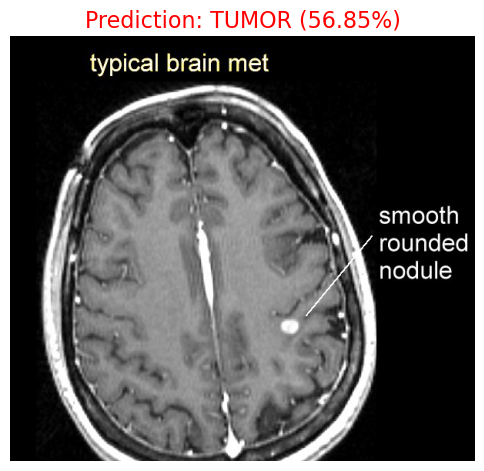

In [37]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tkinter import Tk, filedialog

# ===========================
# Model Class (Same as Before)
# ===========================
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

# ===========================
# Load Model
# ===========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN(num_classes=2).to(device)
model.load_state_dict(torch.load("best_brain_tumor_model.pth", map_location=device))
model.eval()

# Class labels
class_names = ["No Tumor", "Tumor"]

# ===========================
# Image Preprocessing
# ===========================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ===========================
# Upload Image
# ===========================
print("📂 Select an image to test...")
Tk().withdraw()  # Close the root window
img_path = filedialog.askopenfilename(title="Select Brain MRI Image", filetypes=[("Image Files", "*.jpg *.png *.jpeg")])

if not img_path:
    print("❌ No image selected.")
    exit()

# Load image
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# ===========================
# Predict
# ===========================
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    confidence, prediction = torch.max(probs, 1)
    predicted_label = class_names[prediction.item()]
    predicted_conf = confidence.item() * 100

# ===========================
# Show Image & Result
# ===========================
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
title_color = 'green' if predicted_label == "No Tumor" else 'red'
plt.title(f"Prediction: {predicted_label.upper()} ({predicted_conf:.2f}%)", fontsize=16, color=title_color)
plt.show()


In [39]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# Load trained model
model = BrainTumorCNN(num_classes=2)  # change as per your classes
model.load_state_dict(torch.load("best_brain_tumor_model.pth", map_location=torch.device('cpu')))
model.eval()

# Hook for gradients and activations
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks on the last conv layer
target_layer = model.conv_layers[-1]
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

def generate_gradcam(image_path, class_idx=None):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    input_tensor = preprocess(image).unsqueeze(0)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item() if class_idx is None else class_idx

    # Backward pass
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activation_maps = activations.squeeze().detach()

    for i in range(len(pooled_gradients)):
        activation_maps[i] *= pooled_gradients[i]

    heatmap = activation_maps.mean(dim=0).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize and overlay
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.7, heatmap_color, 0.3, 0)

    # Show result
    cv2.imshow("Grad-CAM", superimposed_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Optionally save
    cv2.imwrite("gradcam_result.jpg", superimposed_img)


In [51]:
generate_gradcam("D:/DEVPOST/AI_MODEL (AI-IN -Action)/brain_tumor_dataset/no/No16.jpg")


In [52]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# Load the model
model = BrainTumorCNN(num_classes=2)
model.load_state_dict(torch.load("best_brain_tumor_model.pth", map_location=torch.device('cpu')))
model.eval()

# Global vars to hold hook data
gradients = None
activations = None

# Hook to save gradients
def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Hook to save activations
def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks on the last conv layer
target_layer = model.conv_layers[-1]
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

def generate_gradcam(image_path, class_idx=None):
    # Load & preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    input_tensor = preprocess(image).unsqueeze(0)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item() if class_idx is None else class_idx

    # Backward pass
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    # Grad-CAM calculation
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activation_maps = activations.squeeze().detach()

    for i in range(len(pooled_gradients)):
        activation_maps[i] *= pooled_gradients[i]

    heatmap = activation_maps.mean(dim=0).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize and overlay
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 0.7, heatmap_color, 0.3, 0)

    # Show images side-by-side using matplotlib
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


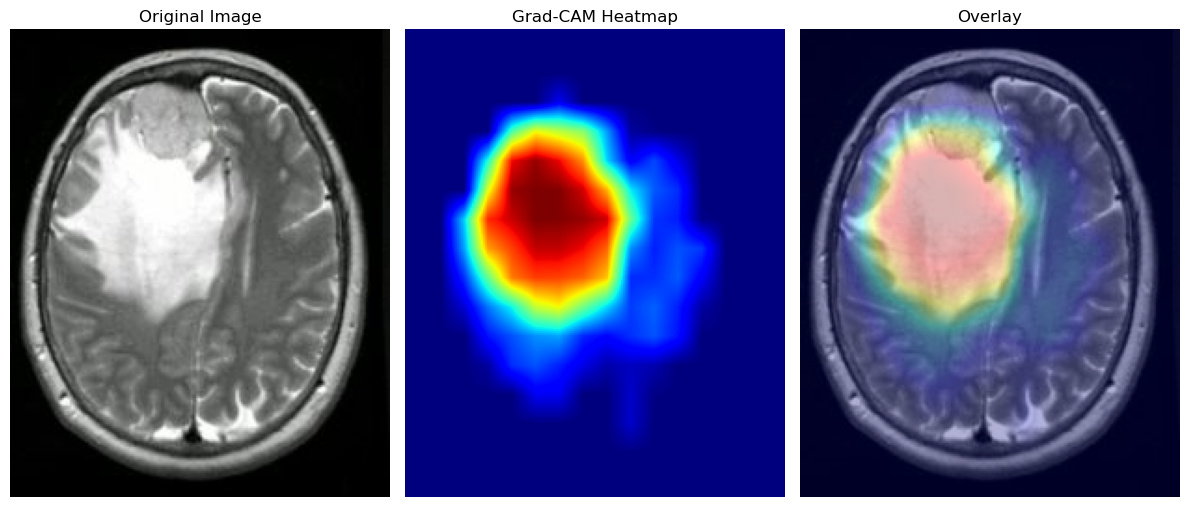

In [54]:
generate_gradcam("D:/DEVPOST/AI_MODEL (AI-IN -Action)/brain_tumor_dataset/yes/Y36.JPG")


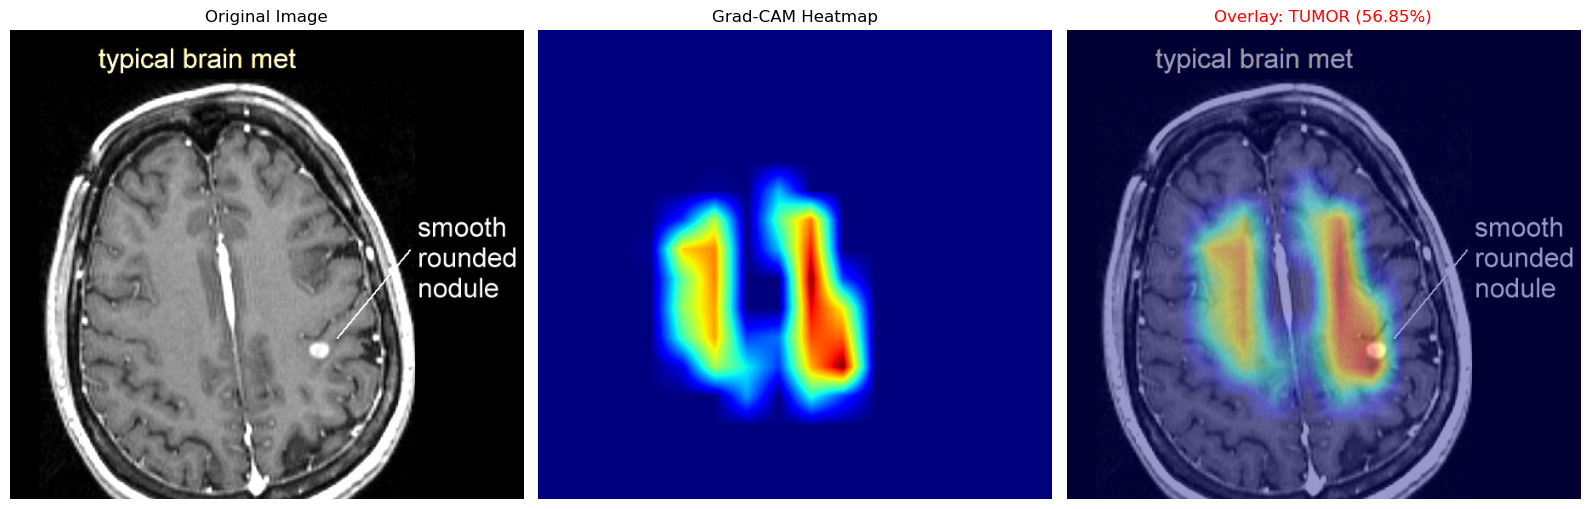

In [55]:
import cv2
import numpy as np

# ===========================
# Grad-CAM Hooking
# ===========================
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks on the last conv layer
target_layer = model.conv_layers[-1]
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Backward pass for Grad-CAM
model.zero_grad()
class_score = output[0, pred_class]
class_score.backward()

# Grad-CAM Calculation
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activation_maps = activations.squeeze().detach()

for i in range(len(pooled_gradients)):
    activation_maps[i] *= pooled_gradients[i]

heatmap = activation_maps.mean(dim=0).cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize heatmap
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(np.array(image), 0.6, heatmap_color, 0.4, 0)

# ===========================
# Display All in One Figure
# ===========================
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay: {predicted_label.upper()} ({predicted_conf:.2f}%)", color=title_color)
plt.axis("off")

plt.tight_layout()
plt.show()


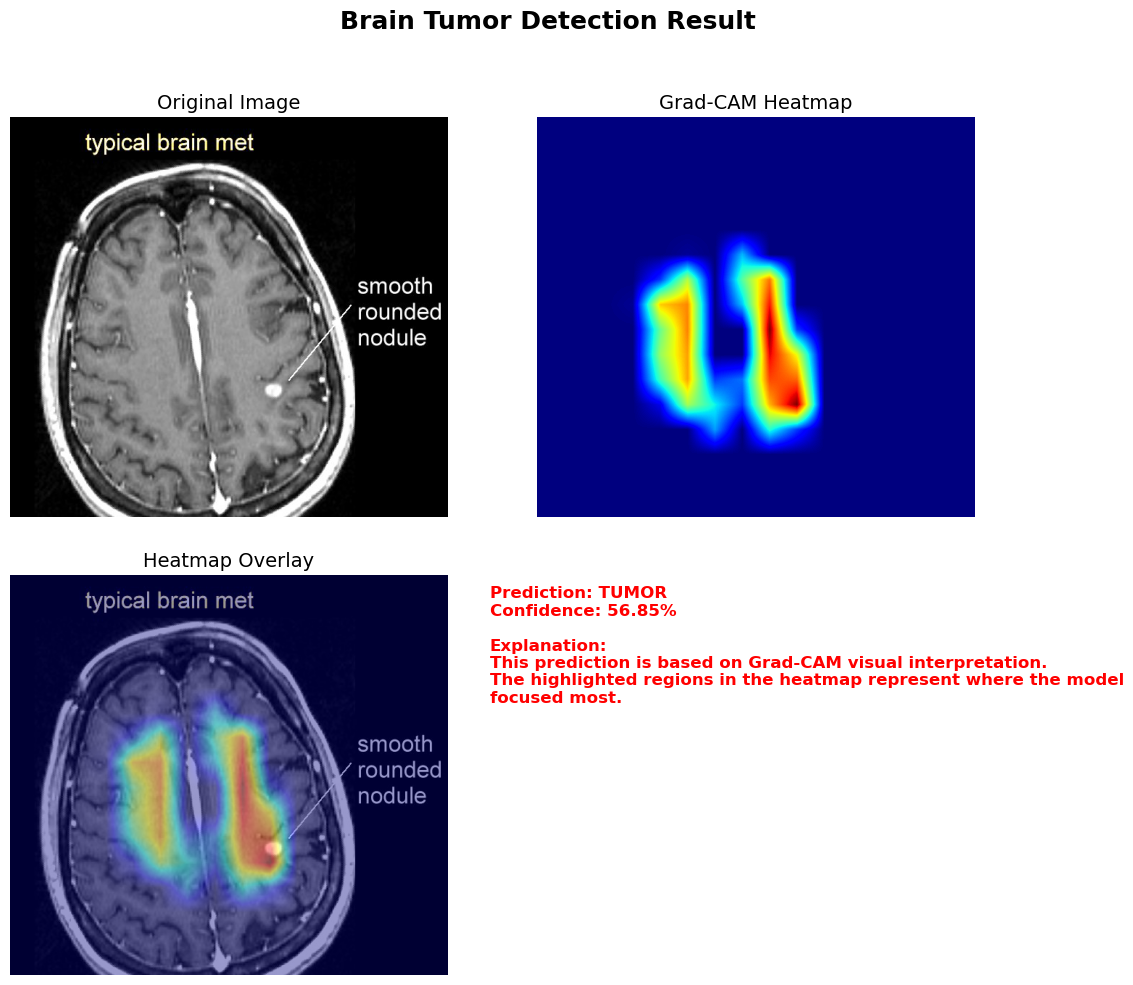

In [56]:
# ===========================
# Display Proper Layout
# ===========================
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Brain Tumor Detection Result", fontsize=18, weight='bold')

# Original Image
axs[0, 0].imshow(image)db
axs[0, 0].set_title("Original Image", fontsize=14)
axs[0, 0].axis("off")

# Grad-CAM Heatmap
axs[0, 1].imshow(heatmap_resized, cmap='jet')
axs[0, 1].set_title("Grad-CAM Heatmap", fontsize=14)
axs[0, 1].axis("off")

# Overlay
axs[1, 0].imshow(overlay)
axs[1, 0].set_title("Heatmap Overlay", fontsize=14)
axs[1, 0].axis("off")

# Prediction Box
axs[1, 1].axis("off")
result_text = f"""
Prediction: {predicted_label.upper()}
Confidence: {predicted_conf:.2f}%

Explanation:
This prediction is based on Grad-CAM visual interpretation.
The highlighted regions in the heatmap represent where the model focused most.

"""
axs[1, 1].text(0, 0.6, result_text, fontsize=12, color=title_color, weight='bold', wrap=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
